In [61]:
!pip install omnixai
!pip install xgboost
!pip install plotly
!pip install OpenAI

In [62]:
from omnixai.data.tabular import Tabular
from omnixai.preprocessing.tabular import TabularTransform
from omnixai.explainers.tabular import TabularExplainer
from openai import OpenAI



# Explanability

Since explainability must be applied to the same model and dataset as in Question 5, we reuse the same preprocessing and training pipeline before generating local LIME explanations

## Load and preprocess Adult dataset

We load and clean the Adult dataset using the same steps as in Question 5.

In [63]:
# Load and preprocess Adult dataset

import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

# Load Adult dataset with correct column names
feature_names = [
    "Age", "Workclass", "fnlwgt", "Education",
    "Education-Num", "Marital Status", "Occupation",
    "Relationship", "Race", "Sex", "Capital Gain",
    "Capital Loss", "Hours per week", "Country", "label"
]

df = pd.DataFrame(
    np.genfromtxt('adult.data.csv', delimiter=',', dtype=str, skip_header=1),
    columns=feature_names
)

# Keep only needed columns
feature_names_reduced = [
    "Age", "Workclass", "Education", "Occupation", "Relationship", 
    "Race", "Sex", "Capital Gain","Capital Loss", "Hours per week", "Country", 
    "label"
]

df = df[feature_names_reduced]

# Drop missing values denoted as ?
cols = list(df.columns)
df[cols] = df[cols].replace(['?'], np.nan)
df = df.dropna()

# 1) Convert label to 0/1 BEFORE numeric casting
df["label"] = df["label"].str.strip()   # remove spaces like ' <=50K'
df["label"] = df["label"].replace('>50K', 1)
df["label"] = df["label"].replace('<=50K', 0)

# Declare categorical columns
categorical_columns = [
   "Workclass", "Education", "Occupation", "Relationship", "Race", "Sex", "Country"
]

# 2) Apply dtypes ONLY to feature columns (exclude 'label')
feature_cols_only = [c for c in feature_names_reduced if c != "label"]

for feature in feature_cols_only:
    if feature in categorical_columns:
        df[feature] = df[feature].astype("category")
    else:
        df[feature] = df[feature].astype("int")

# Make bins for age and hours per week
df['Age'] = pd.cut(df['Age'], bins=[16, 35, 90], labels=['Young','Aged'])
df["Hours per week"] = pd.cut(
    x=df["Hours per week"],
    bins=[0.9, 25, 39, 40, 55, 100],
    labels=["PartTime", "MidTime", "FullTime", "OverTime", "BrainDrain"]
)

# Replace "Husband" and "Wife" with "Married"
df["Relationship"] = df["Relationship"].replace('Husband','Married')
df["Relationship"] = df["Relationship"].replace('Wife','Married')

print("Preprocessed data shape:", df.shape)
df.sample(5)

Preprocessed data shape: (32560, 12)


/var/folders/br/7spnrjm97z37c6809hfphy400000gn/T/ipykernel_54204/3561944221.py:38: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



,Age,Workclass,Education,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,label
23976,Aged,Private,Some-college,Farming-fishing,Husband,White,Male,0,0,BrainDrain,United-States,1
22020,Young,Private,HS-grad,Tech-support,Other-relative,Asian-Pac-Islander,Male,0,0,FullTime,Vietnam,0
14490,Aged,Federal-gov,Some-college,Adm-clerical,Husband,White,Male,0,0,FullTime,United-States,1
8150,Aged,Private,HS-grad,Exec-managerial,Husband,White,Male,0,0,BrainDrain,United-States,1
16794,Aged,Private,HS-grad,Exec-managerial,Own-child,White,Female,0,0,FullTime,United-States,0


## Tabular wrapper and train–test split

We encode the dataset and apply a train–test split consistent with the previous question.

In [64]:
# Tabular wrapper
tabular_data = Tabular(
   df,
   categorical_columns=[
      "Age", "Workclass", "Education", "Occupation", "Relationship", 
      "Race", "Sex", "Hours per week", "Country"
   ],
   target_column='label'
)

transformer = TabularTransform().fit(tabular_data)
class_names = transformer.class_names
x = transformer.transform(tabular_data)

# Train-test split
train, test, train_labels, test_labels = sklearn.model_selection.train_test_split(
    x[:, :-1], x[:, -1], train_size=0.70, random_state=1234
)

test_labels = test_labels.astype(int)

print('Training data shape:', train.shape)
print('Test data shape:', test.shape)

# Convert back to Tabular for explanations
train_data = transformer.invert(train)
test_data = transformer.invert(test)

Training data shape: (22792, 104)
Test data shape: (9768, 104)


# Train and evaluate the XGBoost model

We train the same XGBoost classifier as in Question 5 to ensure consistent evaluation before applying explainability.

Test accuracy: 0.8691
Test: TP=np.int64(1547), TN=np.int64(6942), FP=np.int64(522), FN=np.int64(757)


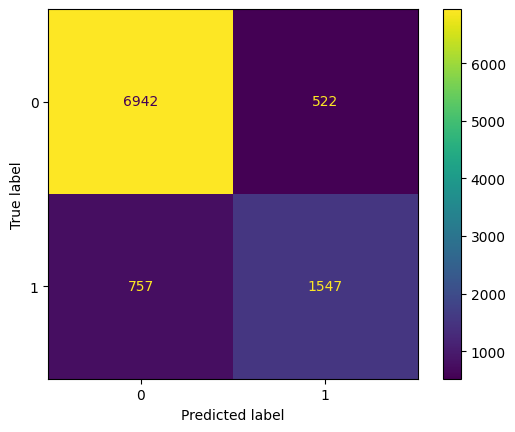

In [65]:
import xgboost as xgboost
import sklearn

# Train an XGBoost model
model = xgboost.XGBClassifier(n_estimators=300, max_depth=5)
model.fit(train, train_labels)

# Predictions on test
predictions = model.predict(test)

# Evaluate
accuracy = sklearn.metrics.accuracy_score(test_labels, predictions)
print(f'Test accuracy: {accuracy:.4f}')

cm = sklearn.metrics.confusion_matrix(test_labels, predictions)
TN, FP, FN, TP = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
print(f"Test: {TP=}, {TN=}, {FP=}, {FN=}")

disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Finding a confident misclassification in the test set

We search the test set for an instance that was misclassified with high confidence, as required for local explainability.

In [66]:
import numpy as np
import sklearn

# Predictions and probabilities on test
predictions = model.predict(test)
proba = model.predict_proba(test)

# Indices where prediction != true label
miss_indices = np.where(predictions != test_labels)[0]

threshold = 0.9  # confidence threshold
miss_but_confident = []

for idx in miss_indices:
    if np.max(proba[idx]) > threshold:
        miss_but_confident.append(idx)

print(f"There are {len(miss_but_confident)} misclassified but confident instances (> {threshold}).")

if len(miss_but_confident) > 0:
    example_id = miss_but_confident[0]
    print(f"Example instance {example_id}:")
    print(f"  True label: {test_labels[example_id]}")
    print(f"  Prediction: {predictions[example_id]}")
    print(f"  Probabilities: {proba[example_id]}")
else:
    example_id = None

There are 156 misclassified but confident instances (> 0.9).
Example instance 123:
  True label: 1
  Prediction: 0
  Probabilities: [0.9323091  0.06769093]


## Local explainability with LIME 

We compute a LIME explanation for the selected misclassified instance and extract feature-importance pairs.

In [67]:
from omnixai.explainers.tabular import TabularExplainer

# Local explainability: LIME + MACE
local_explainers = TabularExplainer(
  explainers=['lime', 'mace'],
  mode="classification",
  data=train_data,
  model=model,
  preprocess=lambda z: transformer.transform(z),
  params={
        "mace": {"ignored_features": ["Sex", "Race"]}
    }
)

# Select instances to explain
if len(miss_but_confident) > 0:
    instance_ids = miss_but_confident[:5]  # first 5 such instances
else:
    instance_ids = [0, 1, 2, 3, 4]

test_instances = test_data[instance_ids]
local_explanations = local_explainers.explain(X=test_instances)

print("LIME results:")
for i, instance_id in enumerate(instance_ids):
    print(f"\nInstance {instance_id}: true={test_labels[instance_id]}, pred={predictions[instance_id]}, proba={proba[instance_id]}")
    local_explanations["lime"].ipython_plot(index=i, class_names=class_names)

/opt/anaconda3/envs/omnixai/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:296: FutureWarning:

The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.



LIME results:

Instance 123: true=1, pred=0, proba=[0.9323091  0.06769093]



Instance 302: true=1, pred=0, proba=[0.926833   0.07316702]



Instance 622: true=1, pred=0, proba=[0.97491086 0.02508914]



Instance 634: true=1, pred=0, proba=[0.94440615 0.05559386]



Instance 658: true=1, pred=0, proba=[0.92205334 0.07794665]


# LLM

We use the Gemma 3-4B model served by LM Studio to generate a natural-language explanation of the feature-importance pairs and to comment on the confident misclassification identified above.

In [68]:
client = OpenAI(
    api_key="google/gemma-3-4b",
    base_url="http://localhost:1234/v1"
)

Each time we interact with it, the LLM starts anew. So we need to store and replay the messages.
And we'll build a function to interact with the LLM. 

In [69]:
messages = [
    {"role": "system", "content": "You are an AI assistant helping a non-technical person understand a prediction of an income classifier."}
]

def get_response(message, messages):
    messages.append({"role": "user", "content": message})
    completion = client.chat.completions.create(
        messages=messages,
        temperature=0.8,
        model="model"
    )
    response = completion.choices[0].message.content
    messages.append({"role": "assistant", "content": response})
    return response, messages

We extracted the feature–importance dictionary produced by the LIME method for the instance that was misclassified with high confidence. The LIME explanations are stored as a list of dictionaries, one dictionary per instance.

In [70]:
lime_all = local_explanations["lime"]        # objet FeatureImportance

We asked the Gemma 3-4B model to provide a natural-language explanation for the first instance based on its LIME feature-importance scores.

In [71]:
instance_id = instance_ids[0]

lime0 = lime_all.explanations[0]            # <-- dict for the instance 1

# lime0 is now a dictionary :
# {'instance': ..., 'features': [...], 'values': [...], 'scores': [...], ...}



# Extract features and scores for the selected instance
features = list(lime0["features"])
scores = [float(s) for s in lime0["scores"]]

# Combine them into a single dictionary (feature-importance pairs)
feature_importances = {
    feat: score
    for feat, score in zip(features, scores)
}

# Build the message (prompt for the LLM)
message = f"""
LIME explanation for instance {instance_id}:

Prediction: {predictions[instance_id]}
Probability: {proba[instance_id]}
True label: {test_labels[instance_id]}

Feature importances:
{feature_importances}
"""
comment = f"\nInstance {instance_id}: true={test_labels[instance_id]}, pred={predictions[instance_id]}, proba={proba[instance_id]}"
response, messages = get_response(message, messages)
print(comment)
print()
print(response)


Instance 123: true=1, pred=0, proba=[0.9323091  0.06769093]

Okay, let's break down what this prediction is saying about instance 123.

**Basically, the income classifier thinks instance 123 has a very low chance of being in a high-income group – it predicts a 0, even though the actual income level (the "True label") is actually a 1 (meaning it *should* be considered a high income).**

Here's what the importance scores tell us:

* **‘Capital Gain’ is the biggest factor (0.641).** This means that how much money this person made from investments (like stocks or property) has a huge impact on the prediction. A negative ‘Capital Gain’ score means they *lost* money, which strongly pushed the classifier towards a low-income prediction.
* **‘Relationship’ is also important (0.122).** The type of relationship this person has – whether they are married, single, etc. – is a significant factor influencing the prediction. 
* **‘Age’ and ‘Education’ are pushing the classifier towards a low-income 

We asked the Gemma 3-4B model to provide a natural-language explanation for the second instance based on its LIME feature-importance scores.

In [72]:
instance_id = instance_ids[1]

lime1 = lime_all.explanations[1]            # <-- dict for the instance 2

# lime1 is now a dictionary :
# {'instance': ..., 'features': [...], 'values': [...], 'scores': [...], ...}



# Extract features and scores for the selected instance
features = list(lime1["features"])
scores = [float(s) for s in lime1["scores"]]

# Combine them into a single dictionary (feature-importance pairs)
feature_importances = {
    feat: score
    for feat, score in zip(features, scores)
}

# Build the message (prompt for the LLM)
message = f"""
LIME explanation for instance {instance_id}:

Prediction: {predictions[instance_id]}
Probability: {proba[instance_id]}
True label: {test_labels[instance_id]}

Feature importances:
{feature_importances}
"""
comment = f"\nInstance {instance_id}: true={test_labels[instance_id]}, pred={predictions[instance_id]}, proba={proba[instance_id]}"
response, messages = get_response(message, messages)
print(comment)
print()
print(response)


Instance 302: true=1, pred=0, proba=[0.926833   0.07316702]

Okay, let’s break down the LIME explanation for instance 302.

**Again, the model predicts a low income (Prediction: 0), even though the actual income level is considered high (True label: 1).**

Let’s examine the feature importances to understand why this might be happening:

* **‘Capital Gain’ is still the dominant factor (0.6857).** Just like with instance 123, a large negative ‘Capital Gain’ score strongly suggests that the model thinks this person *lost* money, contributing to a low-income prediction.
* **‘Relationship’ is slightly negative (-0.1843).** Unlike ‘Capital Gain,’ a negative relationship score here means that this person’s relationship status (e.g., single, married) is subtly pushing the prediction towards a lower income category.
* **‘Age’ is positively influential (0.0857).** This suggests that being older contributes to the low-income prediction, though less strongly than ‘Capital Gain’.
* **‘Occupation’ 

We asked the Gemma 3-4B model to provide a natural-language explanation for the third instance based on its LIME feature-importance scores.

In [73]:
instance_id = instance_ids[2]

lime2 = lime_all.explanations[2]            # <-- dict for the instance 3

# lime2 is now a dictionary :
# {'instance': ..., 'features': [...], 'values': [...], 'scores': [...], ...}



# Extract features and scores for the selected instance
features = list(lime2["features"])
scores = [float(s) for s in lime2["scores"]]

# Combine them into a single dictionary (feature-importance pairs)
feature_importances = {
    feat: score
    for feat, score in zip(features, scores)
}

# Build the message (prompt for the LLM)
message = f"""
LIME explanation for instance {instance_id}:

Prediction: {predictions[instance_id]}
Probability: {proba[instance_id]}
True label: {test_labels[instance_id]}

Feature importances:
{feature_importances}
"""
comment = f"\nInstance {instance_id}: true={test_labels[instance_id]}, pred={predictions[instance_id]}, proba={proba[instance_id]}"
response, messages = get_response(message, messages)
print(comment)
print()
print(response)


Instance 622: true=1, pred=0, proba=[0.97491086 0.02508914]

Okay, let's analyze the LIME explanation for instance 622.

**The model strongly predicts a low income (Prediction: 0), despite the true income being classified as high (True label: 1).**

Let’s break down the feature importances to understand why this discrepancy exists:

* **‘Capital Gain’ remains the most influential factor (0.6249).** This is a very strong negative score, reinforcing the idea that significant investment losses are driving the model’s low-income prediction.
* **‘Relationship’ has a noticeable negative impact (0.1488).** This suggests that this person's relationship status – likely indicating singlehood – is contributing to the low-income prediction.
* **‘Education’ has a small negative effect (-0.1073).** This indicates that the person's level of education is slightly influencing a lower income prediction.
* **‘Occupation’, ‘Hours per week’ and 'Sex' have minor, negative influences (-0.0864, -0.0626, -0.0

We asked the Gemma 3-4B model to provide a natural-language explanation for the fourth instance based on its LIME feature-importance scores.

In [74]:
instance_id = instance_ids[3]

lime3 = lime_all.explanations[3]            # <-- dict for the instance 4

# lime3 is now a dictionary :
# {'instance': ..., 'features': [...], 'values': [...], 'scores': [...], ...}



# Extract features and scores for the selected instance
features = list(lime3["features"])
scores = [float(s) for s in lime3["scores"]]

# Combine them into a single dictionary (feature-importance pairs)
feature_importances = {
    feat: score
    for feat, score in zip(features, scores)
}

# Build the message (prompt for the LLM)
message = f"""
LIME explanation for instance {instance_id}:

Prediction: {predictions[instance_id]}
Probability: {proba[instance_id]}
True label: {test_labels[instance_id]}

Feature importances:
{feature_importances}
"""
comment = f"\nInstance {instance_id}: true={test_labels[instance_id]}, pred={predictions[instance_id]}, proba={proba[instance_id]}"
response, messages = get_response(message, messages)
print(comment)
print()
print(response)


Instance 634: true=1, pred=0, proba=[0.94440615 0.05559386]

Okay, let’s dissect the LIME explanation for instance 634.

**Again, the model predicts a low income (Prediction: 0), despite the true income being classified as high (True label: 1).**

Let’s examine the feature importances to understand why this is happening:

* **‘Capital Gain’ continues to dominate (0.6689).** The negative ‘Capital Gain’ score remains extremely powerful, highlighting significant investment losses as the key driver of this incorrect prediction.
* **‘Relationship’ has a moderate negative impact (0.1220).** Similar to previous instances, this suggests that singlehood is contributing to a lower income prediction.
* **‘Education’ has a small negative effect (-0.1194).**  This indicates that lower levels of education are potentially impacting the income prediction.
* **‘Occupation’, ‘Age’ and ‘Sex’ have minor, negative influences (-0.0759, -0.0732, -0.0650).** These suggest that job type and age are contributi

We asked the Gemma 3-4B model to provide a natural-language explanation for the fifth and final instance based on its LIME feature-importance scores.

In [75]:
instance_id = instance_ids[4]

lime4 = lime_all.explanations[4]            # <-- dict for the instance 5

# lime4 is now a dictionary :
# {'instance': ..., 'features': [...], 'values': [...], 'scores': [...], ...}



# Extract features and scores for the selected instance
features = list(lime4["features"])
scores = [float(s) for s in lime4["scores"]]

# Combine them into a single dictionary (feature-importance pairs)
feature_importances = {
    feat: score
    for feat, score in zip(features, scores)
}

# Build the message (prompt for the LLM)
message = f"""
LIME explanation for instance {instance_id}:

Prediction: {predictions[instance_id]}
Probability: {proba[instance_id]}
True label: {test_labels[instance_id]}

Feature importances:
{feature_importances}
"""
comment = f"\nInstance {instance_id}: true={test_labels[instance_id]}, pred={predictions[instance_id]}, proba={proba[instance_id]}"
response, messages = get_response(message, messages)
print(comment)
print()
print(response)


Instance 658: true=1, pred=0, proba=[0.92205334 0.07794665]

Okay, let's analyze the LIME explanation for instance 658.

**Again, the model predicts a low income (Prediction: 0), even though the true income level is classified as high (True label: 1).**

Let’s examine the feature importances to understand why this prediction is occurring:

* **‘Capital Gain’ remains a dominant factor (0.6629).** An extremely negative ‘Capital Gain’ score continues to emphasize the strong influence of investment losses on the prediction.
* **‘Capital Loss’ has a notable negative impact (-0.1085).** This is interesting! Having *experienced* a capital loss (as opposed to just the potential for one) significantly contributes to the model's low-income prediction.
* **‘Relationship’ is moderately negative (0.0810).**  Singlehood continues to be a factor, though less powerfully than investment losses.
* **‘Age’ is slightly negative (-0.0723).** Older age appears to correlate with lower income predictions.
* 

Below we show the prompt sent to the Gemma 3-4B model and its natural-language explanation generated for the selected instance.

In [76]:
messages

[{'role': 'system',
  'content': 'You are an AI assistant helping a non-technical person understand a prediction of an income classifier.'},
 {'role': 'user',
  'content': "\nLIME explanation for instance 123:\n\nPrediction: 0\nProbability: [0.9323091  0.06769093]\nTrue label: 1\n\nFeature importances:\n{'Capital Gain': 0.641057512661154, 'Relationship': 0.12262157436976585, 'Age': -0.0868057893899724, 'Education': -0.0772852185332747, 'Occupation': -0.06914763678608428, 'Sex': 0.06535421174186143, 'Capital Loss': 0.049367278284432194, 'Race': -0.01908138342505437, 'Country': -0.010633335201237704, 'Workclass': 0.0058534914088821015}\n"},
 {'role': 'assistant',
  'content': 'Okay, let\'s break down what this prediction is saying about instance 123.\n\n**Basically, the income classifier thinks instance 123 has a very low chance of being in a high-income group – it predicts a 0, even though the actual income level (the "True label") is actually a 1 (meaning it *should* be considered a hi